# URDaVa: Unlearning-Robust Data Valuation for Machine Learning

This notebook is the main record for experiments in this research. All the datasets used for experiments are cited in the paper. All the cells in this notebook is runnable, given that the required dependencies are installed.

## Data Source Ranking

Theoretically, URDV is able to differentiate data sources based on their contributions to model performance and model robustness. In this set of experiments, we investigate URDV's ability to rank data sources based on **data quality** and **staying probability** respectively while keeping the other constant.

### Varying Data Quality

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from urdava.coalition_probability import IndependentCoalitionProbability
from urdava.data_source import generate_random_data_sources, add_classification_noise
from urdava.data_valuation import ValuableModel
from urdava.dataset import load_dataset
from urdava.model_utility import IClassificationModel, model_logistic_regression

X, y = load_dataset('phoneme')

NUM_OF_DATA_SOURCES = 10
support_set = tuple(range(NUM_OF_DATA_SOURCES))
staying_probabilities = {i:0.8 for i in range(NUM_OF_DATA_SOURCES)}
coalition_probability = IndependentCoalitionProbability(staying_probabilities)

average_values = {}
average_noisy_values = {}
average_reverse_noisy_values = {}

model = model_logistic_regression

N = 50
for n_iter in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    y_train_copy = y_train.copy()
    y_train_copy = add_classification_noise(y_train_copy, noise_level = 0.225)
    data_sources = generate_random_data_sources(X_train, y_train_copy, 
                                                num_of_data_sources=NUM_OF_DATA_SOURCES)
    noisy_data_sources = generate_random_data_sources(X_train, y_train, 
                                                      num_of_data_sources=NUM_OF_DATA_SOURCES)
    reverse_noisy_data_sources = generate_random_data_sources(X_train, y_train, 
                                                              num_of_data_sources=NUM_OF_DATA_SOURCES)
    for i in range(NUM_OF_DATA_SOURCES):
        noisy_data_sources[i] = (noisy_data_sources[i][0], 
                                 add_classification_noise(noisy_data_sources[i][1], noise_level = 0.05*i))
        reverse_noisy_data_sources[i] = (reverse_noisy_data_sources[i][0],
                                         add_classification_noise(reverse_noisy_data_sources[i][1], 
                                                                  noise_level = 0.45-0.05*i))

    print(f"=====> Iteration #{n_iter}")

    # no noise
    model_utility_function = IClassificationModel(model, data_sources, X_test, y_test)
    valuable_model = ValuableModel(support_set, model_utility_function)
    values = valuable_model.valuate(data_valuation_function="robust banzhaf", 
                                    coalition_probability=coalition_probability)
    
    for i in values:
        if average_values.get(i, 0) == 0:
            average_values[i] = 0
        average_values[i] += values[i]


    # increasing noise
    model_utility_function = IClassificationModel(model, noisy_data_sources, X_test, y_test)
    noisy_valuable_model = ValuableModel(support_set, model_utility_function)
    noisy_values = noisy_valuable_model.valuate(data_valuation_function="robust banzhaf", 
                                    coalition_probability=coalition_probability)
    
    for i in noisy_values:
        if average_noisy_values.get(i, 0) == 0:
            average_noisy_values[i] = 0
        average_noisy_values[i] += noisy_values[i]
        
    # decreasing noise
    model_utility_function = IClassificationModel(model, reverse_noisy_data_sources, X_test, y_test)
    reverse_noisy_valuable_model = ValuableModel(support_set, model_utility_function)
    reverse_noisy_values = reverse_noisy_valuable_model.valuate(data_valuation_function="robust banzhaf", 
                                    coalition_probability=coalition_probability)
    
    for i in reverse_noisy_values:
        if average_reverse_noisy_values.get(i, 0) == 0:
            average_reverse_noisy_values[i] = 0
        average_reverse_noisy_values[i] += reverse_noisy_values[i]

# get average
for i in average_values:
    average_values[i] /= N
    average_noisy_values[i] /= N
    average_reverse_noisy_values[i] /= N

=====> Iteration #0
=====> Iteration #1
=====> Iteration #2
=====> Iteration #3
=====> Iteration #4
=====> Iteration #5
=====> Iteration #6
=====> Iteration #7
=====> Iteration #8
=====> Iteration #9
=====> Iteration #10
=====> Iteration #11
=====> Iteration #12
=====> Iteration #13
=====> Iteration #14
=====> Iteration #15
=====> Iteration #16
=====> Iteration #17
=====> Iteration #18
=====> Iteration #19
=====> Iteration #20
=====> Iteration #21
=====> Iteration #22
=====> Iteration #23
=====> Iteration #24
=====> Iteration #25
=====> Iteration #26
=====> Iteration #27
=====> Iteration #28
=====> Iteration #29
=====> Iteration #30
=====> Iteration #31
=====> Iteration #32
=====> Iteration #33
=====> Iteration #34
=====> Iteration #35
=====> Iteration #36
=====> Iteration #37
=====> Iteration #38
=====> Iteration #39
=====> Iteration #40
=====> Iteration #41
=====> Iteration #42
=====> Iteration #43
=====> Iteration #44
=====> Iteration #45
=====> Iteration #46
=====> Iteration #47
==

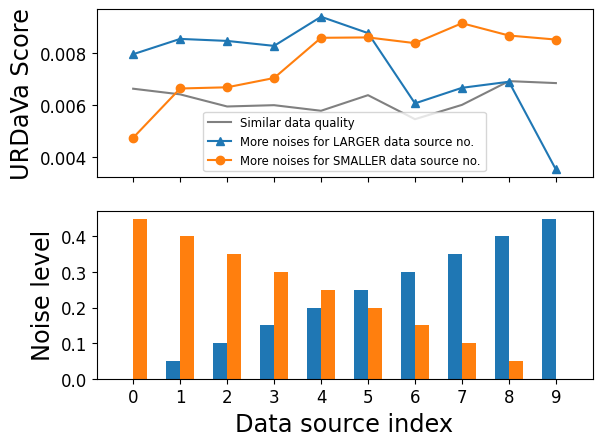

In [3]:
import numpy as np
import os

fig, ax = plt.subplots(2, sharex=True)
line, = ax[0].plot(average_values.values(), color="grey")
line.set_label("Similar data quality")
noisy_line, = ax[0].plot(average_noisy_values.values(), marker="^", color="C0")
noisy_line.set_label("More noises for LARGER data source no.")
reverse_noisy_line, = ax[0].plot(average_reverse_noisy_values.values(), marker="o", color="C1")
reverse_noisy_line.set_label("More noises for SMALLER data source no.")
ax[0].legend(loc="lower center", fontsize="small")
ax[0].set_ylabel("URDaVa Score", fontsize='xx-large')
ax[1].set_xlabel("Data source index", fontsize='xx-large')
ax[1].set_xticks(ticks=list(range(NUM_OF_DATA_SOURCES)))
ax[1].set_ylabel("Noise level", fontsize='xx-large')
width = 0.3
multiplier = 0
x = np.arange(NUM_OF_DATA_SOURCES)
noises = [0.05*i for i in range(NUM_OF_DATA_SOURCES)]
reverse_noises = [(0.45 - 0.05*i) for i in range(NUM_OF_DATA_SOURCES)]
all_noises = [noises, reverse_noises]
for i in range(len(all_noises)):
    offset = width * multiplier
    ax[1].bar(x + offset - width/2, all_noises[i], width, color=f"C{i}")
    multiplier += 1
    
ax[0].tick_params(axis='both', labelsize='large')
ax[1].tick_params(axis='both', labelsize='large')
    
plt.show()
PATH_TO_IMAGES = "./images/data_source_ranking/"
if not os.path.isdir(PATH_TO_IMAGES):
    os.makedirs(PATH_TO_IMAGES)
fig.savefig(os.path.join(PATH_TO_IMAGES, "data_quality_10_banzhaf_phoneme.png"), dpi=300)

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from urdava.coalition_probability import IndependentCoalitionProbability
from urdava.data_source import generate_random_data_sources, add_classification_noise
from urdava.data_valuation import ValuableModel
from urdava.dataset import load_dataset
from urdava.model_utility import IClassificationModel, model_linear_svm

X, y = load_dataset('diabetes')

NUM_OF_DATA_SOURCES = 10
support_set = tuple(range(NUM_OF_DATA_SOURCES))
staying_probabilities = {i:0.8 for i in range(NUM_OF_DATA_SOURCES)}
coalition_probability = IndependentCoalitionProbability(staying_probabilities)

average_values = {}
average_noisy_values = {}
average_reverse_noisy_values = {}

model = model_linear_svm

N = 20
for n_iter in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    y_train_copy = y_train.copy()
    y_train_copy = add_classification_noise(y_train_copy, noise_level = 0.225)
    data_sources = generate_random_data_sources(X_train, y_train_copy, 
                                                num_of_data_sources=NUM_OF_DATA_SOURCES)
    noisy_data_sources = generate_random_data_sources(X_train, y_train, 
                                                      num_of_data_sources=NUM_OF_DATA_SOURCES)
    reverse_noisy_data_sources = generate_random_data_sources(X_train, y_train, 
                                                              num_of_data_sources=NUM_OF_DATA_SOURCES)
    for i in range(NUM_OF_DATA_SOURCES):
        noisy_data_sources[i] = (noisy_data_sources[i][0], 
                                 add_classification_noise(noisy_data_sources[i][1], noise_level = 0.05*i))
        reverse_noisy_data_sources[i] = (reverse_noisy_data_sources[i][0],
                                         add_classification_noise(reverse_noisy_data_sources[i][1], 
                                                                  noise_level = 0.45-0.05*i))

    print(f"=====> Iteration #{n_iter}")

    # no noise
    model_utility_function = IClassificationModel(model, data_sources, X_test, y_test)
    valuable_model = ValuableModel(support_set, model_utility_function)
    values = valuable_model.valuate(data_valuation_function="robust beta", 
                                    coalition_probability=coalition_probability, alpha=16, beta=4)
    
    for i in values:
        if average_values.get(i, 0) == 0:
            average_values[i] = 0
        average_values[i] += values[i]


    # increasing noise
    model_utility_function = IClassificationModel(model, noisy_data_sources, X_test, y_test)
    noisy_valuable_model = ValuableModel(support_set, model_utility_function)
    noisy_values = noisy_valuable_model.valuate(data_valuation_function="robust beta", 
                                    coalition_probability=coalition_probability, alpha=16, beta=4)
    
    for i in noisy_values:
        if average_noisy_values.get(i, 0) == 0:
            average_noisy_values[i] = 0
        average_noisy_values[i] += noisy_values[i]
        
    # decreasing noise
    model_utility_function = IClassificationModel(model, reverse_noisy_data_sources, X_test, y_test)
    reverse_noisy_valuable_model = ValuableModel(support_set, model_utility_function)
    reverse_noisy_values = reverse_noisy_valuable_model.valuate(data_valuation_function="robust beta", 
                                    coalition_probability=coalition_probability, alpha=16, beta=4)
    
    for i in reverse_noisy_values:
        if average_reverse_noisy_values.get(i, 0) == 0:
            average_reverse_noisy_values[i] = 0
        average_reverse_noisy_values[i] += reverse_noisy_values[i]

# get average
for i in average_values:
    average_values[i] /= N
    average_noisy_values[i] /= N
    average_reverse_noisy_values[i] /= N

=====> Iteration #0
=====> Iteration #1
=====> Iteration #2
=====> Iteration #3
=====> Iteration #4
=====> Iteration #5
=====> Iteration #6
=====> Iteration #7
=====> Iteration #8
=====> Iteration #9
=====> Iteration #10
=====> Iteration #11
=====> Iteration #12
=====> Iteration #13
=====> Iteration #14
=====> Iteration #15
=====> Iteration #16
=====> Iteration #17
=====> Iteration #18
=====> Iteration #19


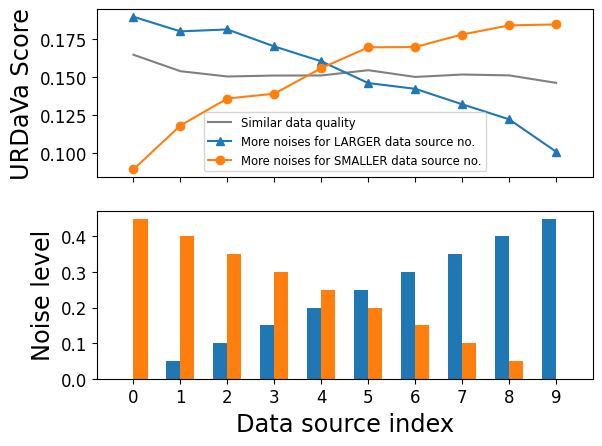

In [3]:
import numpy as np
import os

fig, ax = plt.subplots(2, sharex=True)
line, = ax[0].plot(average_values.values(), color="grey")
line.set_label("Similar data quality")
noisy_line, = ax[0].plot(average_noisy_values.values(), marker="^", color="C0")
noisy_line.set_label("More noises for LARGER data source no.")
reverse_noisy_line, = ax[0].plot(average_reverse_noisy_values.values(), marker="o", color="C1")
reverse_noisy_line.set_label("More noises for SMALLER data source no.")
ax[0].legend(loc="lower center", fontsize="small")
ax[0].set_ylabel("URDaVa Score", fontsize='xx-large')
ax[1].set_xlabel("Data source index", fontsize='xx-large')
ax[1].set_xticks(ticks=list(range(NUM_OF_DATA_SOURCES)))
ax[1].set_ylabel("Noise level", fontsize='xx-large')
width = 0.3
multiplier = 0
x = np.arange(NUM_OF_DATA_SOURCES)
noises = [0.05*i for i in range(NUM_OF_DATA_SOURCES)]
reverse_noises = [(0.45 - 0.05*i) for i in range(NUM_OF_DATA_SOURCES)]
all_noises = [noises, reverse_noises]
for i in range(len(all_noises)):
    offset = width * multiplier
    ax[1].bar(x + offset - width/2, all_noises[i], width, color=f"C{i}")
    multiplier += 1
    
ax[0].tick_params(axis='both', labelsize='large')
ax[1].tick_params(axis='both', labelsize='large')
    
plt.show()
PATH_TO_IMAGES = "./images/data_source_ranking/"
if not os.path.isdir(PATH_TO_IMAGES):
    os.makedirs(PATH_TO_IMAGES)
fig.savefig(os.path.join(PATH_TO_IMAGES, "data_quality_10_svm_credit_card.png"), dpi=300)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from urdava.coalition_probability import IndependentCoalitionProbability
from urdava.data_source import generate_random_data_sources, add_classification_noise
from urdava.data_valuation import ValuableModel
from urdava.dataset import load_dataset
from urdava.model_utility import IClassificationModel, model_gaussian_nb

# Add logs
import logging
import sys
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(lineno)s - %(levelname)s - %(message)s')
logger.setLevel(logging.DEBUG)

fhandler = logging.FileHandler(filename='main.log', mode='w')
fhandler.setFormatter(formatter)
fhandler.setLevel(logging.INFO)
logger.addHandler(fhandler)

consoleHandler = logging.StreamHandler(sys.stdout)
consoleHandler.setFormatter(formatter)
consoleHandler.setLevel(logging.DEBUG)
logger.addHandler(consoleHandler)

logger.info("Program has started.")

X, y = load_dataset('wind')

NUM_OF_DATA_SOURCES = 20
support_set = tuple(range(NUM_OF_DATA_SOURCES))
staying_probabilities = {i:0.9 for i in range(NUM_OF_DATA_SOURCES)}
coalition_probability = IndependentCoalitionProbability(staying_probabilities)

average_values = {}
average_noisy_values = {}
average_reverse_noisy_values = {}

model = model_gaussian_nb

N = 20
for n_iter in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    y_train_copy = y_train.copy()
    y_train_copy = add_classification_noise(y_train_copy, noise_level = 0.225)
    data_sources = generate_random_data_sources(X_train, y_train_copy, 
                                                num_of_data_sources=NUM_OF_DATA_SOURCES)
    noisy_data_sources = generate_random_data_sources(X_train, y_train, 
                                                      num_of_data_sources=NUM_OF_DATA_SOURCES)
    reverse_noisy_data_sources = generate_random_data_sources(X_train, y_train, 
                                                              num_of_data_sources=NUM_OF_DATA_SOURCES)
    for i in range(NUM_OF_DATA_SOURCES):
        noisy_data_sources[i] = (noisy_data_sources[i][0], 
                                 add_classification_noise(noisy_data_sources[i][1], noise_level = 0.025*i))
        reverse_noisy_data_sources[i] = (reverse_noisy_data_sources[i][0],
                                         add_classification_noise(reverse_noisy_data_sources[i][1], 
                                                                  noise_level = 0.45-0.025*i))

    print(f"=====> Iteration #{n_iter}")

    # no noise
    model_utility_function = IClassificationModel(model, data_sources, X_test, y_test)
    valuable_model = ValuableModel(support_set, model_utility_function)
    values = valuable_model.valuate(data_valuation_function="012-mcmc robust shapley", 
                                    coalition_probability=coalition_probability, tol=1.0005)
    
    for i in values:
        if average_values.get(i, 0) == 0:
            average_values[i] = 0
        average_values[i] += values[i]


    # increasing noise
    model_utility_function = IClassificationModel(model, noisy_data_sources, X_test, y_test)
    noisy_valuable_model = ValuableModel(support_set, model_utility_function)
    noisy_values = noisy_valuable_model.valuate(data_valuation_function="012-mcmc robust shapley", 
                                    coalition_probability=coalition_probability, tol=1.0005)
    
    for i in noisy_values:
        if average_noisy_values.get(i, 0) == 0:
            average_noisy_values[i] = 0
        average_noisy_values[i] += noisy_values[i]
        
    # decreasing noise
    model_utility_function = IClassificationModel(model, reverse_noisy_data_sources, X_test, y_test)
    reverse_noisy_valuable_model = ValuableModel(support_set, model_utility_function)
    reverse_noisy_values = reverse_noisy_valuable_model.valuate(data_valuation_function="012-mcmc robust shapley", 
                                    coalition_probability=coalition_probability, tol=1.0005)
    
    for i in reverse_noisy_values:
        if average_reverse_noisy_values.get(i, 0) == 0:
            average_reverse_noisy_values[i] = 0
        average_reverse_noisy_values[i] += reverse_noisy_values[i]
        
    logger.info(f"Iteration {n_iter} has completed.")

# get average
for i in average_values:
    average_values[i] /= N
    average_noisy_values[i] /= N
    average_reverse_noisy_values[i] /= N
    
logger.info(f"=====> Average values: {str(average_values)}")
logger.info(f"=====> Average noisy values: {str(average_noisy_values)}")
logger.info(f"=====> Average reverse noisy values: {str(average_reverse_noisy_values)}")
    


In [ ]:
import numpy as np
import os

fig, ax = plt.subplots(2, sharex=True)
line, = ax[0].plot(average_values.values(), color="grey")
line.set_label("Similar data quality")
noisy_line, = ax[0].plot(average_noisy_values.values(), marker="^", color="C0")
noisy_line.set_label("More noises for LARGER data source no.")
reverse_noisy_line, = ax[0].plot(average_reverse_noisy_values.values(), marker="o", color="C1")
reverse_noisy_line.set_label("More noises for SMALLER data source no.")
ax[0].legend(loc="lower center", fontsize="small")
ax[0].set_ylabel("URDaVa Score", fontsize='xx-large')
ax[1].set_xlabel("Data source index", fontsize='xx-large')
ax[1].set_xticks(ticks=list(range(NUM_OF_DATA_SOURCES)))
ax[1].set_ylabel("Noise level", fontsize='xx-large')
width = 0.3
multiplier = 0
x = np.arange(NUM_OF_DATA_SOURCES)
noises = [0.025*i for i in range(NUM_OF_DATA_SOURCES)]
reverse_noises = [(0.45 - 0.025*i) for i in range(NUM_OF_DATA_SOURCES)]
all_noises = [noises, reverse_noises]
for i in range(len(all_noises)):
    offset = width * multiplier
    ax[1].bar(x + offset - width/2, all_noises[i], width, color=f"C{i}")
    multiplier += 1
    
ax[0].tick_params(axis='both', labelsize='large')
ax[1].tick_params(axis='both', labelsize='large')
    
plt.show()
PATH_TO_IMAGES = "./images/data_source_ranking/"
if not os.path.isdir(PATH_TO_IMAGES):
    os.makedirs(PATH_TO_IMAGES)
fig.savefig(os.path.join(PATH_TO_IMAGES, "data_quality_20_shapley_wind.png"), dpi=300)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from urdava.coalition_probability import IndependentCoalitionProbability
from urdava.data_source import generate_random_data_sources, add_classification_noise
from urdava.data_valuation import ValuableModel
from urdava.dataset import load_dataset
from urdava.model_utility import IClassificationModel, model_gaussian_nb

# Add logs
import logging
import sys
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(lineno)s - %(levelname)s - %(message)s')
logger.setLevel(logging.DEBUG)

fhandler = logging.FileHandler(filename='main2.log', mode='w')
fhandler.setFormatter(formatter)
fhandler.setLevel(logging.INFO)
logger.addHandler(fhandler)

consoleHandler = logging.StreamHandler(sys.stdout)
consoleHandler.setFormatter(formatter)
consoleHandler.setLevel(logging.DEBUG)
logger.addHandler(consoleHandler)

logger.info("Program has started.")

X, y = load_dataset('credit card')

NUM_OF_DATA_SOURCES = 20
support_set = tuple(range(NUM_OF_DATA_SOURCES))
staying_probabilities = {i:0.9 for i in range(NUM_OF_DATA_SOURCES)}
coalition_probability = IndependentCoalitionProbability(staying_probabilities)

average_values = {}
average_noisy_values = {}
average_reverse_noisy_values = {}

model = model_gaussian_nb

N = 20
for n_iter in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    y_train_copy = y_train.copy()
    y_train_copy = add_classification_noise(y_train_copy, noise_level = 0.225)
    data_sources = generate_random_data_sources(X_train, y_train_copy, 
                                                num_of_data_sources=NUM_OF_DATA_SOURCES)
    noisy_data_sources = generate_random_data_sources(X_train, y_train, 
                                                      num_of_data_sources=NUM_OF_DATA_SOURCES)
    reverse_noisy_data_sources = generate_random_data_sources(X_train, y_train, 
                                                              num_of_data_sources=NUM_OF_DATA_SOURCES)
    for i in range(NUM_OF_DATA_SOURCES):
        noisy_data_sources[i] = (noisy_data_sources[i][0], 
                                 add_classification_noise(noisy_data_sources[i][1], noise_level = 0.025*i))
        reverse_noisy_data_sources[i] = (reverse_noisy_data_sources[i][0],
                                         add_classification_noise(reverse_noisy_data_sources[i][1], 
                                                                  noise_level = 0.45-0.025*i))

    print(f"=====> Iteration #{n_iter}")

    # no noise
    model_utility_function = IClassificationModel(model, data_sources, X_test, y_test)
    valuable_model = ValuableModel(support_set, model_utility_function)
    values = valuable_model.valuate(data_valuation_function="012-mcmc robust beta", 
                                    coalition_probability=coalition_probability, tol=1.0005, alpha=4, beta=16)
    
    for i in values:
        if average_values.get(i, 0) == 0:
            average_values[i] = 0
        average_values[i] += values[i]


    # increasing noise
    model_utility_function = IClassificationModel(model, noisy_data_sources, X_test, y_test)
    noisy_valuable_model = ValuableModel(support_set, model_utility_function)
    noisy_values = noisy_valuable_model.valuate(data_valuation_function="012-mcmc robust beta", 
                                    coalition_probability=coalition_probability, tol=1.0005, alpha=4, beta=16)
    
    for i in noisy_values:
        if average_noisy_values.get(i, 0) == 0:
            average_noisy_values[i] = 0
        average_noisy_values[i] += noisy_values[i]
        
    # decreasing noise
    model_utility_function = IClassificationModel(model, reverse_noisy_data_sources, X_test, y_test)
    reverse_noisy_valuable_model = ValuableModel(support_set, model_utility_function)
    reverse_noisy_values = reverse_noisy_valuable_model.valuate(data_valuation_function="012-mcmc robust beta", 
                                    coalition_probability=coalition_probability, tol=1.0005, alpha=4, beta=16)
    
    for i in reverse_noisy_values:
        if average_reverse_noisy_values.get(i, 0) == 0:
            average_reverse_noisy_values[i] = 0
        average_reverse_noisy_values[i] += reverse_noisy_values[i]
        
    logger.info(f"Iteration {n_iter} has completed.")

# get average
for i in average_values:
    average_values[i] /= N
    average_noisy_values[i] /= N
    average_reverse_noisy_values[i] /= N
    
logger.info(f"=====> Average values: {str(average_values)}")
logger.info(f"=====> Average noisy values: {str(average_noisy_values)}")
logger.info(f"=====> Average reverse noisy values: {str(average_reverse_noisy_values)}")
    


In [ ]:
import numpy as np
import os

fig, ax = plt.subplots(2, sharex=True)
line, = ax[0].plot(average_values.values(), color="grey")
line.set_label("Similar data quality")
noisy_line, = ax[0].plot(average_noisy_values.values(), marker="^", color="C0")
noisy_line.set_label("More noises for LARGER data source no.")
reverse_noisy_line, = ax[0].plot(average_reverse_noisy_values.values(), marker="o", color="C1")
reverse_noisy_line.set_label("More noises for SMALLER data source no.")
ax[0].legend(loc="lower center", fontsize="small")
ax[0].set_ylabel("URDaVa Score", fontsize='xx-large')
ax[1].set_xlabel("Data source index", fontsize='xx-large')
ax[1].set_xticks(ticks=list(range(NUM_OF_DATA_SOURCES)))
ax[1].set_ylabel("Noise level", fontsize='xx-large')
width = 0.3
multiplier = 0
x = np.arange(NUM_OF_DATA_SOURCES)
noises = [0.025*i for i in range(NUM_OF_DATA_SOURCES)]
reverse_noises = [(0.45 - 0.025*i) for i in range(NUM_OF_DATA_SOURCES)]
all_noises = [noises, reverse_noises]
for i in range(len(all_noises)):
    offset = width * multiplier
    ax[1].bar(x + offset - width/2, all_noises[i], width, color=f"C{i}")
    multiplier += 1
    
ax[0].tick_params(axis='both', labelsize='large')
ax[1].tick_params(axis='both', labelsize='large')
    
plt.show()
PATH_TO_IMAGES = "./images/data_source_ranking/"
if not os.path.isdir(PATH_TO_IMAGES):
    os.makedirs(PATH_TO_IMAGES)
fig.savefig(os.path.join(PATH_TO_IMAGES, "data_quality_20_beta_credit_card.png"), dpi=300)

## Effect on Duplicates

Although duplicated data may contribute less to model performance due to the existence of its "twins", it is contributing to model robustness. Therefore, its URDaVa score might be higher than its prior score. In this experiment, we assign different probability to our data source of interest and other data sources to investigate when its URDaVa score would be higher than prior score (i.e. contribution to model robustness is more than contribution to model performance).

### Synthetic Dataset

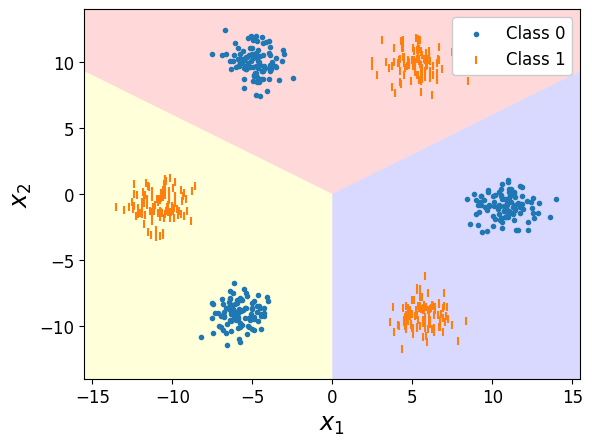

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from sklearn.datasets import make_blobs

centers = [(-5, 10), (5, 10),
           (5 * 1.67 + 2.5, -5 + 2.5 * 1.67), (5 * 1.67 - 2.5, -5 - 2.5 * 1.67), 
           (-5 * 1.67 + 2.5, -5 - 2.5 * 1.67), (-5 * 1.67 - 2.5, -5 + 2.5 * 1.67)]
n_samples_per_cluster = 100

X_0 = X_1 = np.ndarray((0, 2), dtype='float')
y_0 = y_1 = np.array([])
for i in range(3):
    X_temp_0, y_temp_0 = make_blobs(n_samples=n_samples_per_cluster, centers=centers[2 * i: 2 * i + 1], shuffle=False)
    X_0 = np.concatenate((X_0, X_temp_0))
    y_0 = np.concatenate((y_0, np.full(n_samples_per_cluster, 0)))
    X_temp_1, y_temp_1 = make_blobs(n_samples=n_samples_per_cluster, centers=centers[2 * i + 1: 2 * i + 2], shuffle=False)
    X_1 = np.concatenate((X_1, X_temp_1))
    y_1 = np.concatenate((y_1, np.full(n_samples_per_cluster, 1)))
    if i == 0:
        X_red = np.concatenate((X_temp_0, X_temp_1))
        y_red = np.concatenate((np.full(n_samples_per_cluster, 0), np.full(n_samples_per_cluster, 1)))
    elif i == 1:
        X_yellow = np.concatenate((X_temp_0, X_temp_1))
        y_yellow = np.concatenate((np.full(n_samples_per_cluster, 0), np.full(n_samples_per_cluster, 1)))
    else:
        X_blue = np.concatenate((X_temp_0, X_temp_1))
        y_blue = np.concatenate((np.full(n_samples_per_cluster, 0), np.full(n_samples_per_cluster, 1)))

fig, ax = plt.subplots()

region_red = Polygon(np.array([[0, 0], [-25, 15], [25, 15]]), closed=True)
region_yellow = Polygon(np.array([[0, 0], [-25, 15], [0, -100]]), closed=True)
region_blue = Polygon(np.array([[0, 0], [25, 15], [0, -100]]), closed=True)
patches = [region_red, region_yellow, region_blue]
p = PatchCollection(patches, alpha=0.15)
p.set(facecolor=['red', 'yellow', 'blue'])
ax.add_collection(p)

ax.scatter(X_0[:, 0], X_0[:, 1], marker='.', label='Class 0')
ax.scatter(X_1[:, 0], X_1[:, 1], marker='|', label='Class 1')

ax.set_xlabel(r'$x_1$', fontsize='xx-large')
ax.set_ylabel(r'$x_2$', fontsize='xx-large')
ax.set_xlim(left=-15.5, right=15.5)
ax.set_ylim(bottom=-14, top=14)
ax.legend(facecolor='white', framealpha=1, fontsize='large', loc='upper right')
ax.tick_params(axis='both', labelsize='large')

plt.show()
PATH_TO_IMAGES = "./images/effect_on_duplicates/"
if not os.path.isdir(PATH_TO_IMAGES):
    os.makedirs(PATH_TO_IMAGES)
fig.savefig(os.path.join(PATH_TO_IMAGES, "synthetic_dataset_visualization.png"), dpi=300)

In [18]:
from sklearn.model_selection import train_test_split

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.3, shuffle=True)
X_red_train, X_redd_train, y_red_train, y_redd_train = train_test_split(X_red_train, y_red_train, test_size=0.5, shuffle=True)
X_yellow_train, X_yellow_test, y_yellow_train, y_yellow_test = train_test_split(X_yellow, y_yellow, test_size=0.3, shuffle=True)
X_blue_train, X_blue_test, y_blue_train, y_blue_test = train_test_split(X_blue, y_blue, test_size=0.3, shuffle=True)
X_test = np.concatenate((X_red_test, X_yellow_test, X_blue_test))
y_test = np.concatenate((y_red_test, y_yellow_test, y_blue_test))
RED = (X_red_train, y_red_train)
REDD = (X_redd_train, y_redd_train)
YELLOW = (X_yellow_train, y_yellow_train)
BLUE = (X_blue_train, y_blue_train)

In [19]:
from urdava.data_valuation import ValuableModel
from urdava.model_utility import IClassificationModel, model_knn

data_sources = {0: RED, 1: REDD, 2: YELLOW, 3: BLUE}
model_utility_function = IClassificationModel(model_knn, data_sources, X_test, y_test)

valuable_model = ValuableModel((0, 1, 2, 3), model_utility_function)

In [20]:
from urdava.coalition_probability import IndependentCoalitionProbability

x = [[] for i in range(6)]
y = [[] for i in range(6)]

for i in range(6): # 100%, 80%, 60%, 40%, 20%, 0%:
    x[i] = [1 - 0.05 * j for j in range(21)]
    for j in range(21): # 100%, 95%, ..., 5%, 0%
        coalition_probability = IndependentCoalitionProbability({0: 1 - 0.05 * j, 1: 1 - 0.2 * i, 
                                                                 2: 1 - 0.2 * i, 3: 1 - 0.2 * i})
        y[i].append(valuable_model.valuate(data_valuation_function='robust banzhaf', 
                                           coalition_probability=coalition_probability)[0])

In [21]:
banzhaf_score = valuable_model.valuate(data_valuation_function='banzhaf')[0]

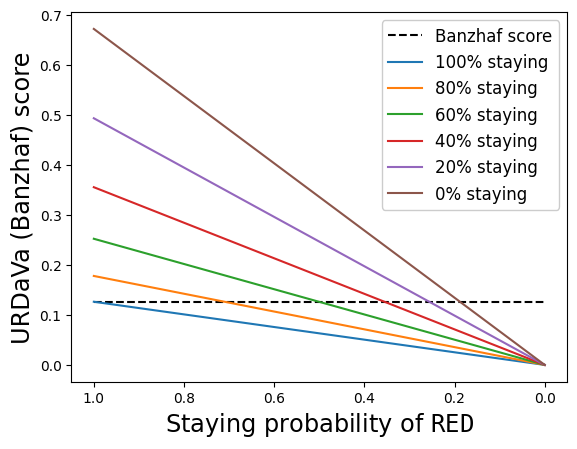

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x[0], [banzhaf_score] * 21, linestyle='dashed', color='black', label='Banzhaf score')
for i in range(6):
    ax.plot(x[i], y[i], color='C' + str(i), label=f'{round((1 - 0.2 * i)*100)}% staying')
    
ax.set_xlabel(r'Staying probability of $\mathtt{RED}$', fontsize='xx-large')
ax.set_ylabel('URDaVa (Banzhaf) score', fontsize='xx-large')
ax.legend(facecolor='white', framealpha=1, fontsize='large', loc='upper right')
plt.gca().invert_xaxis()
PATH_TO_IMAGES = "./images/effect_on_duplicates/"
if not os.path.isdir(PATH_TO_IMAGES):
    os.makedirs(PATH_TO_IMAGES)
fig.savefig(os.path.join(PATH_TO_IMAGES, "synthetic_dataset_result.png"), dpi=300)

### Actual Dataset

In [24]:
from sklearn.model_selection import train_test_split
from urdava.dataset import load_dataset
from urdava.data_source import generate_random_data_sources

X, y = load_dataset('phoneme')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
data_sources = generate_random_data_sources(X_train, y_train)

In [25]:
data_sources[10] = (data_sources[0][0].copy(), data_sources[0][1].copy()) # 10 is a duplicate of 0

In [26]:
from urdava.data_valuation import ValuableModel
from urdava.model_utility import IClassificationModel, model_logistic_regression

model_utility_function = IClassificationModel(model_logistic_regression, data_sources, X_test, y_test)

valuable_model = ValuableModel(tuple([i for i in range(11)]), model_utility_function)

In [ ]:
from urdava.coalition_probability import IndependentCoalitionProbability

x = [[] for i in range(6)]
y = [[] for i in range(6)]

for i in range(6): # 100%, 80%, 60%, 40%, 20%, 0%:
    x[i] = [1 - 0.1 * j for j in range(11)]
    for j in range(11): # 100%, 90%, ..., 10%, 0%
        probabilities = {d:1-0.2*i for d in range(1, 11)}
        probabilities[0] = 1 - 0.1 * j
        coalition_probability = IndependentCoalitionProbability(probabilities)
        y[i].append(valuable_model.valuate(data_valuation_function='robust shapley', 
                                           coalition_probability=coalition_probability)[0])
        print(1)

In [28]:
shapley_score = valuable_model.valuate(data_valuation_function='shapley')[0]

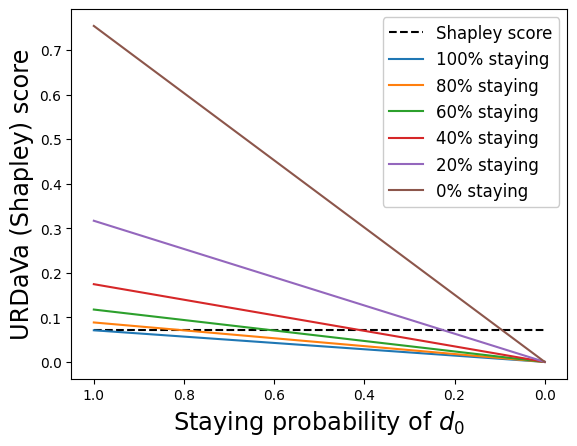

In [29]:
import matplotlib.pyplot as plt
import os

fig, ax = plt.subplots()
ax.plot(x[0], [shapley_score] * 11, linestyle='dashed', color='black', label='Shapley score')
for i in range(6):
    ax.plot(x[i], y[i], color='C' + str(i), label=f'{round((1 - 0.2 * i)*100)}% staying')
    
ax.set_xlabel(r'Staying probability of $d_0$', fontsize='xx-large')
ax.set_ylabel('URDaVa (Shapley) score', fontsize='xx-large')
ax.legend(facecolor='white', framealpha=1, fontsize='large', loc='upper right')
plt.gca().invert_xaxis()
PATH_TO_IMAGES = "./images/effect_on_duplicates/"
if not os.path.isdir(PATH_TO_IMAGES):
    os.makedirs(PATH_TO_IMAGES)
fig.savefig(os.path.join(PATH_TO_IMAGES, "actual_dataset_result.png"), dpi=300)